# Generating mocks

Load standard libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import astropy.io.fits as fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy import units
from astropy import constants as cn

Initialise the mock model to the initial values of test model

In [2]:
import mcclusters.generate_mock as mock
from mcclusters.models.triaxial_nfw import TriaxialNFW as Model
from mcclusters.initial_values import test

mock.model = Model( mock.coord, tscale=( mock.tscale * mock.C0 ).cgs.value )

for v in test():
    if v.name in mock.model.__dict__:
        mock.model.__dict__[ v.name ].itemset( v.item() )

mock.model.update()

Initialising models
Initialising observables
Initialising clustersmc
dz: 0.04744448256384348 kpc	px: 15.873015873015873 kpc


Let's generate the observable and plot them

In [3]:
redges = np.logspace( np.log10(60.), np.log10( mock.side.value * 0.9 / 2. ), 9 )
dm2d, em2d, tprof = mock.get_observables( mock.model, sidesl=False, redges=redges )

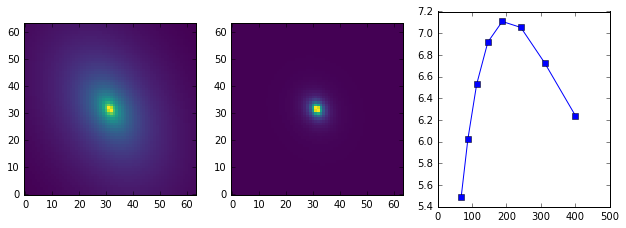

In [4]:
plt.close('all')

fig, ax = plt.subplots( nrows=1, ncols=3, figsize=(3.5*3,3.5) )

ax[0].imshow( dm2d.T, origin='lower', cmap='viridis', interpolation='none' )

ax[1].imshow( em2d.T, origin='lower', cmap='viridis', interpolation='none' )

ax[2].plot( redges[:-1] + np.diff(redges)/2., tprof, 's-' )
ax[2].set_xlim( 0, 500 );

Now let's add noise to the strong lensing observable

In [5]:
dm2d_err = 0.05

sidesl = mock.side
Nxsl = Nysl = mock.Nx

slx = np.linspace( -1, 1., Nxsl ) * sidesl / 2.
sly = np.linspace( -1, 1., Nysl ) * sidesl / 2.


# Create mask
xsl, ysl = np.meshgrid( slx, sly, sparse=False, indexing='ij' )
rrSL = np.sqrt(xsl**2+ysl**2)
mask = np.ones( ( Nxsl, Nysl ) )


sigsl = dm2d * dm2d_err
avg = dm2d + np.random.normal( scale=sigsl, size=dm2d.shape )


# Fill the header data unit
hdu = fits.PrimaryHDU( avg )
hdu.name = 'avg'
hdulist = fits.HDUList( [ hdu ] )
hdulist.append( fits.ImageHDU( sigsl, name='sigma' ) )
hdulist.append( fits.ImageHDU( mask, name='mask' ) )
hdulist.append( fits.ImageHDU( slx.value, name='x' ) )
hdulist.append( fits.ImageHDU( sly.value, name='y' ) )


# And save it
path = './'
outfile = path+'sl_obs.fits'
hdulist.writeto( outfile, clobber=True )

The X-ray temperature

In [6]:
# Let's save the temperature arrays in dictionary,
# so it's easier to throw them in the fits file

rin = redges[:-1]
rout = redges[1:]
rref = redges[:-1] + np.diff(redges)/2.

Xtemp_obs = {}
Xtemp_obs['rout'] = rout
Xtemp_obs['rin'] = rin
Xtemp_obs['rref_x'] = rref

# Add some noise to the 1d profile
Xtemp_obs['ekt'] = tprof * 0.05
Xtemp_obs['kt'] = np.random.normal( loc=tprof, scale=Xtemp_obs['ekt'] )


Table(Xtemp_obs).write( path+'xtemp_obs.fits', format='fits', overwrite=True )

And finally the X-ray surface brightness

In [7]:
rate = 60. * np.ones( em2d.shape[:-1] ) / units.s
livetime = 8e4 * units.s
bkg = 0.1

mask = np.ones( em2d.shape[:-1] )

norm = rate * livetime * 1e-14 * 0.826 * units.cm**5  \
/ ( 4. * np.pi * mock.cosmo.angular_diameter_distance( mock.redsh )**2 * (1+mock.redsh)**2 )

    
hdu = fits.PrimaryHDU( scipy.stats.poisson( em2d + bkg ).rvs() )
hdu.name = 'imhbmap'
hdu.header['bkg'] = bkg
hdu.header['scale'] = ( mock.scale.value, 'kpc/px' )
hdulist = fits.HDUList([hdu])

hdulist.append( fits.ImageHDU( norm.cgs.value, name='k' ) )
hdulist.append( fits.ImageHDU( mask, name='maskbmap' ) )
hdulist.append( fits.ImageHDU( mock.x.value, name='xbmap' ) )
hdulist.append( fits.ImageHDU( mock.y.value, name='ybmap' ) )

outfile = path+'bmap_obs.fits'
hdulist.writeto( outfile, clobber=True )

